In [1]:
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
import kipoi
import pandas as pd
import matplotlib.pyplot as plt
import sequence
import ucscgenome
import evaluation_tools
import numpy as np
import pickle
from keras.losses import mae
from keras.models import load_model
from tqdm import tqdm

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# get model
sys.path.append("/home/thouis/anaconda3/envs/kipoi-Basenji/lib/python3.5/site-packages/")  # noqa
model = kipoi.get_model('Basenji')

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))
/home/kal/K27act_models/bin/atacseq.py:280: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


INFO:tensorflow:Restoring parameters from model_files/model.tf


In [2]:
#load in data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
peaks = pd.read_table(peaks_path)
peaks['score'] = np.nan
peaks['logk27act'] = np.log(peaks['k27act'].clip(0) +1)


# get test set
subpeaks = peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)]
cutoff = len(subpeaks)//32
subpeaks=subpeaks[:cutoff*32]
print(len(subpeaks))
subpeaks.head()

3392


,chr,start,end,name,fold_change,atac,k27act,nucs,gc_frac,cpg_frac,score,logk27act
149099,chr8,156467,157491,Peak_83609_ENCFF996CVE_dhs,-3.863588,13.556464,0.000000,ccgccgggcggggagcgcgggaatggcgaggtgcaggcgcagagac...,0.600586,0.044922,NaN,0.000000
149101,chr8,181990,183014,Peak_28905_ENCFF411MHX_k27,0.030627,31.354554,32.048760,ACCCAGAGGCGGAGTGCGGGCTCGCGAGGGTCCCCACCCGACTCTC...,0.679688,0.100586,NaN,3.497984
149103,chr8,221994,223018,Peak_53539_ENCFF411MHX_k27,0.094396,6.295875,6.789209,TCACACGACCTGCGGGGCGCCCCAGAGGCCAGGCGGCCGCTGGTTC...,0.534180,0.023438,NaN,2.052739
149105,chr8,223740,224764,Peak_34885_ENCFF411MHX_k27,1.279614,3.187324,9.165738,ggggactgaggggtgggggaagggggtgtggggtggaaggtgtaga...,0.575195,0.016602,NaN,2.319023
149107,chr8,354258,355282,Peak_38696_ENCFF411MHX_k27,0.569372,7.128076,11.061070,GTGTGGTGTGCATTGGAGAAGCGTGGGACCCCTGTGCTCACCACCA...,0.478516,0.006836,NaN,2.489983


In [14]:
# pickeled models
kbaseline_models = {'Regression':pickle.load(open('/home/kal/K27act_models/regression_models/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}

# keras models
custom_dict = {'loss_with_grad':mae, 'grad_penalty':mae}
logkml_models = {'PWM':load_model('/home/kal/K27act_models/pwm_models/20180803_164937_mae_loss/final_model.h5')}

In [4]:
def bed_gen(peaks, genome, alt=False, seq_length=1024):
    """Generate sequnces from bed data.
    """
    peaks['position'] = (peaks['start'] + peaks['end'])//2
    for index, row in peaks.iterrows():
        seq = sequence.encode_to_onehot(genome[row['chr']][row['position']-seq_length//2:row['position']+seq_length//2])
        yield seq

In [5]:
# predict with basenji
def predict_bed(model, peaks, genome=None, act=False, seq_length=131072, 
                batch_size=2, output_index=0, location_index=(131072//128)//2):
    """Predict from a bed file with chr, start, end.
 
    """
     # get the genome and bed file regions
    if genome == None:
        genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
    # predict over the rows
    preds = []
    batchgen = evaluation_tools.filled_batch(bed_gen(peaks, genome, alt=False, seq_length=seq_length), 
                                          fillvalue=np.zeros((seq_length, 4)), batch_size=batch_size)
    for batch in tqdm(batchgen, total=len(peaks)/batch_size) :
        if batch.shape == (batch_size, seq_length, 4):
            full = model.predict_on_batch(batch)
            preds.append(full[:,location_index, output_index].copy())
    preds = np.asarray(preds).reshape(-1)[:len(peaks)]
    return preds

In [20]:
minipeaks=subpeaks.sample(64)

In [22]:
# gm128 K27act is in tthe  2171 th output
preds = predict_bed(model, minipeaks, output_index=2171)



  0%|          | 0/32.0 [00:00<?, ?it/s]

  3%|▎         | 1/32.0 [00:00<00:25,  1.24it/s]

  6%|▋         | 2/32.0 [00:01<00:23,  1.26it/s]

  9%|▉         | 3/32.0 [00:02<00:23,  1.23it/s]

 12%|█▎        | 4/32.0 [00:03<00:22,  1.26it/s]

 16%|█▌        | 5/32.0 [00:03<00:20,  1.30it/s]

 19%|█▉        | 6/32.0 [00:04<00:19,  1.31it/s]

 22%|██▏       | 7/32.0 [00:05<00:18,  1.32it/s]

 25%|██▌       | 8/32.0 [00:06<00:18,  1.33it/s]

 28%|██▊       | 9/32.0 [00:06<00:17,  1.35it/s]

 31%|███▏      | 10/32.0 [00:07<00:16,  1.33it/s]

 34%|███▍      | 11/32.0 [00:08<00:15,  1.38it/s]

 38%|███▊      | 12/32.0 [00:08<00:13,  1.46it/s]

 41%|████      | 13/32.0 [00:09<00:12,  1.50it/s]

 44%|████▍     | 14/32.0 [00:10<00:11,  1.55it/s]

 47%|████▋     | 15/32.0 [00:10<00:10,  1.59it/s]

 50%|█████     | 16/32.0 [00:11<00:09,  1.62it/s]

 53%|█████▎    | 17/32.0 [00:11<00:09,  1.62it/s]

 56%|█████▋    | 18/32.0 [00:12<00:08,  1.61it/s]

 59%|█████▉    | 19/32.0 [00:13<00:08,  1.62it/

In [23]:
preds2 = predict_bed(model, minipeaks, output_index=2551)



  0%|          | 0/32.0 [00:00<?, ?it/s]

  3%|▎         | 1/32.0 [00:00<00:23,  1.32it/s]

  6%|▋         | 2/32.0 [00:01<00:22,  1.32it/s]

  9%|▉         | 3/32.0 [00:02<00:21,  1.33it/s]

 12%|█▎        | 4/32.0 [00:03<00:21,  1.33it/s]

 16%|█▌        | 5/32.0 [00:03<00:20,  1.30it/s]

 19%|█▉        | 6/32.0 [00:04<00:19,  1.31it/s]

 22%|██▏       | 7/32.0 [00:05<00:19,  1.30it/s]

 25%|██▌       | 8/32.0 [00:06<00:18,  1.29it/s]

 28%|██▊       | 9/32.0 [00:06<00:17,  1.31it/s]

 31%|███▏      | 10/32.0 [00:07<00:16,  1.33it/s]

 34%|███▍      | 11/32.0 [00:08<00:15,  1.34it/s]

 38%|███▊      | 12/32.0 [00:09<00:14,  1.35it/s]

 41%|████      | 13/32.0 [00:09<00:14,  1.36it/s]

 44%|████▍     | 14/32.0 [00:10<00:13,  1.34it/s]

 47%|████▋     | 15/32.0 [00:11<00:12,  1.34it/s]

 50%|█████     | 16/32.0 [00:12<00:11,  1.35it/s]

 53%|█████▎    | 17/32.0 [00:12<00:11,  1.35it/s]

 56%|█████▋    | 18/32.0 [00:13<00:10,  1.34it/s]

 59%|█████▉    | 19/32.0 [00:14<00:09,  1.34it/

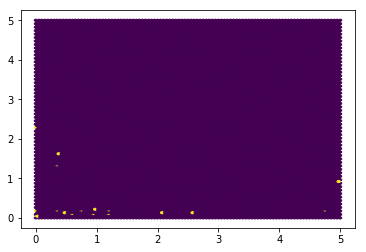

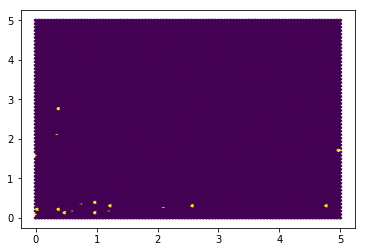

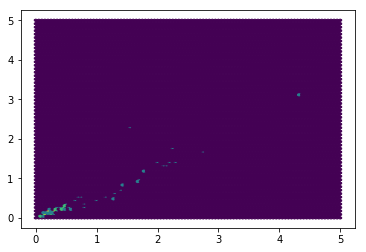

In [25]:
plt.hexbin(minipeaks['k27act'],preds, bins='log', extent=(0, 5, 0, 5))
plt.show()

plt.hexbin(minipeaks['k27act'],preds2, bins='log', extent=(0, 5, 0, 5))
plt.show()

plt.hexbin(preds2,preds, bins='log', extent=(0, 5, 0, 5))
plt.show()

In [12]:
# renormalize with linear regression?
from sklearn.linear_model import LinearRegression
repreds = preds.reshape(-1, 1)
print(repreds.shape)

lm = LinearRegression()
lm.fit(repreds, subpeaks['k27act'])
fit_preds=lm.predict(repreds)

(3392, 1)


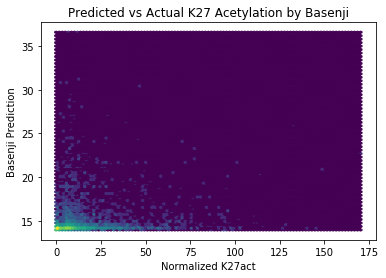

In [28]:
plt.title('Predicted vs Actual K27 Acetylation by Basenji')
plt.xlabel('Normalized K27act')
plt.ylabel('Basenji Prediction')
plt.hexbin(subpeaks['k27act'], fit_preds, bins='log')
plt.show()

In [13]:
logkpreds = np.log(fit_preds.clip(0) + 1)
fpreds = np.log2((fit_preds+1)/(subpeaks['atac']+1))

In [15]:
d = evaluation_tools.compare_models(subpeaks, kbaselines=kbaseline_models, logkmls=logkml_models, graph_list=[])

In [16]:
d2 = pd.DataFrame({'fold_change': {'Basenji':fpreds}, 'k27act':{'Basenji':fit_preds}, 'logk27act':{'Basenji':logkpreds}})
d = d.append(d2)

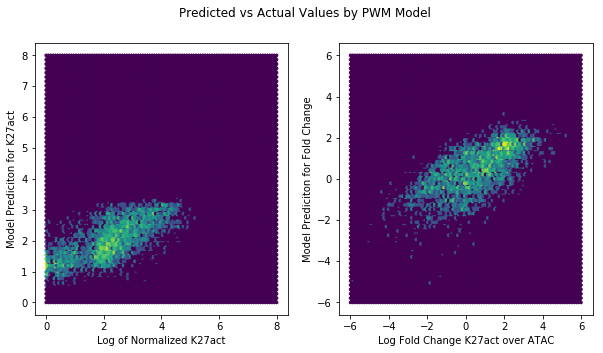

'PWM'


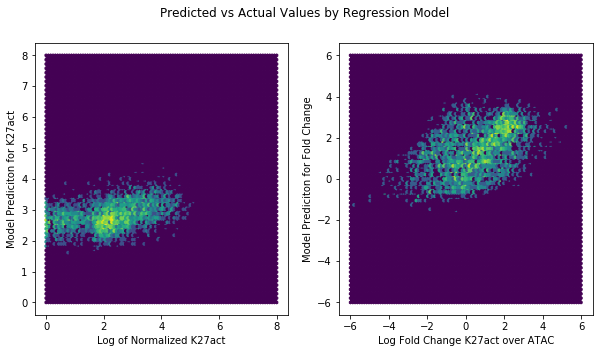

'Regression'


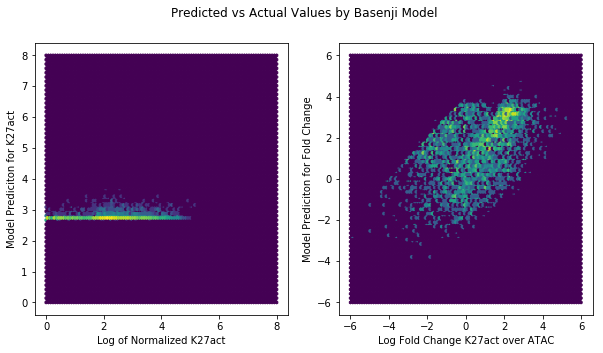

'Basenji'


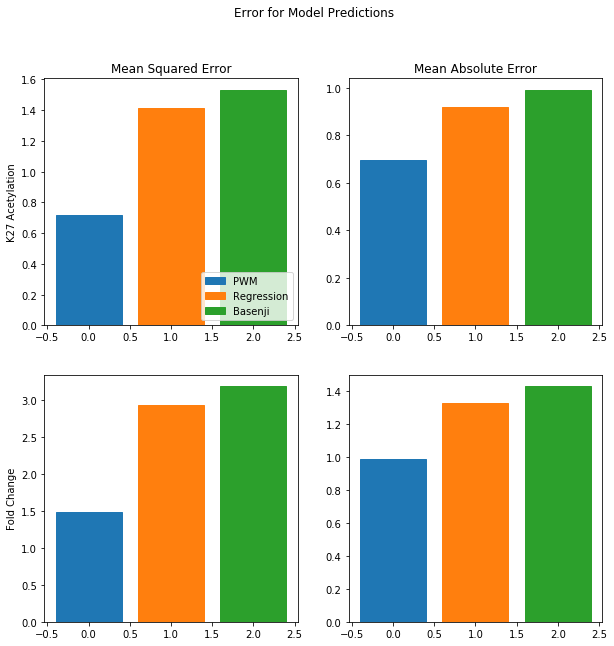

'PWM'
'Regression'
'Basenji'


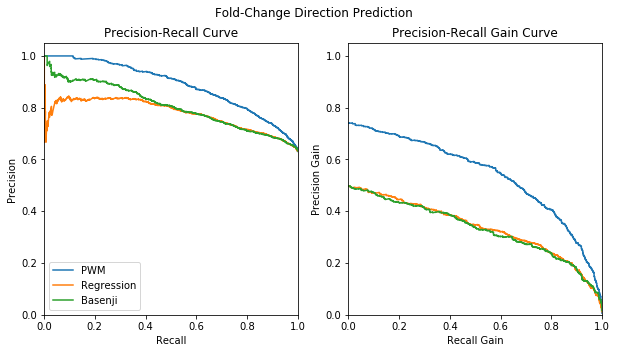

'PWM'
'Regression'
'Basenji'


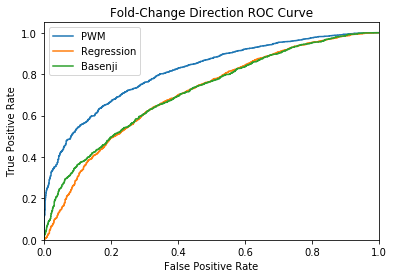

'PWM'
'Regression'
'Basenji'


In [17]:
subpeaks['logk27act'] = np.log(subpeaks['k27act'].clip(0) +1)

evaluation_tools.graph_predframe(d, subpeaks)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.suptitle('Predicted vs Actual Values by Basenji Model')
ax1.set_xlabel('Normalized K27act')
ax1.set_ylabel('Model Prediciton for K27act')
ax2.set_xlabel('Log Fold Change K27act over ATAC')
ax2.set_ylabel('Model Prediciton for Fold Change')
ax1.hexbin(subpeaks['k27act'], d['k27act']['Basenji'], bins='log', extent=(0, 8, 0, 8))
ax2.hexbin(subpeaks['fold_change'], d['fold_change']['Basenji'], bins='log', extent=(-6, 6, -6, 6))
plt.show()

In [ ]:
(131072//128)//2